In [1]:
subj = "Subj1"
exp = "exp_final"

n_stages = [ 9, 8, 10 ][int(subj[-1:]) - 1]
scale = False

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

import os

import SDA
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

import mne
import tqdm
import numpy
import pandas

pandas.set_option("display.precision", 2)

### Data

In [133]:
data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif")
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")
df_features = pandas.read_feather(f"{subj}/{exp}/features.feather")
features = df_features.to_numpy()
print('Features: ', features.shape)

Opening raw data file Subj1/src/data_rr_filt-raw.fif...
    Range : 3500 ... 471000 =      7.000 ...   942.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj1\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
Features:  (1046, 16)


In [134]:
if subj == "Subj2": # m8 (artifacts at the end)
    epochs = epochs[:-2]
    if exp != "reproduction": features = features[:-2]

### SDA

In [135]:
result, df_st_edges = SDA.SDA(scale = scale).apply(features)

Applying to 1046 samples with 16 features each
Running stage 1


  0%|          | 0/589 [00:00<?, ?it/s]

Running stage 2


  0%|          | 0/672 [00:00<?, ?it/s]

In [136]:
if exp != "reproduction":
    edges_true = numpy.loadtxt(f"{subj}/reproduction/internal/best_edges.txt").astype(numpy.int32)
    print(edges_true)

    metrics = [ ]
    for row in tqdm.tqdm(result['St_edges']):
        metrics.append(SDA.clustquality.cluster_metrics_ground(edges_true, row))
    result = pandas.concat([ result, pandas.DataFrame(metrics) ], axis = 1)

[   0   39  282  492  560  682  784  857  976 1046]


100%|██████████| 2016/2016 [00:06<00:00, 302.57it/s]


In [137]:
result.to_csv(f"{subj}/{exp}/result.csv")
df_st_edges.to_csv(f"{subj}/{exp}/df_st_edges.csv")

### Analysis

In [138]:
def analyze(result: pandas.DataFrame, key: str, folder: str):
    if not os.path.exists(f"{subj}/{exp}/{folder}"):
        os.makedirs(f"{subj}/{exp}/{folder}")

    results = SDA.analytics.best_results(result, key = key)
    results.to_csv(f"{subj}/{exp}/{folder}/results.csv")
    display(results)
    
    best_result = SDA.analytics.best_result(result, key = key, n_stages = n_stages)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{subj}/{exp}/{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{subj}/{exp}/{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    edge_statistics = SDA.analytics.edge_statistics(features, best_edges)
    edge_statistics.to_csv(f"{subj}/{exp}/{folder}/edge_statistics.csv")
    display(edge_statistics)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{subj}/{exp}/{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_stats(features, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/stats.svg")
    SDA.analytics.plot_features(df_features, best_edges).savefig(f"{subj}/{exp}/{folder}/features.svg")
    SDA.analytics.plot_eeg_stages(data, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/eeg_stages.svg")

#### Internal

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,40,35,10,3,Mode,"[0, 239, 682, 1046]",64735.31,16.69,1.04e-01,295.86,4.28,0.20,270.77,3.45,0.61,0.39,0.57
1,0,35,10,4,Mode,"[0, 277, 682, 795, 1046]",56399.49,20.00,8.12e-02,247.07,6.60,0.25,243.87,1.44,0.74,0.57,0.69
2,0,50,10,5,Mode,"[0, 277, 556, 682, 795, 1046]",45626.59,21.94,8.11e-02,252.47,2.62,0.32,263.80,1.16,0.82,0.71,0.78
3,60,40,10,6,Median,"[0, 277, 554, 682, 842, 976, 1046]",41186.32,21.32,6.82e-02,229.80,3.87,0.32,234.22,1.14,0.86,0.78,0.83
4,40,40,10,7,Median,"[0, 52, 277, 554, 682, 842, 976, 1046]",32596.73,19.70,1.79e-02,205.56,3.72,0.28,189.16,1.30,0.87,0.81,0.84
5,0,35,15,8,Median,"[0, 43, 205, 277, 554, 682, 842, 976, 1046]",21819.67,17.96,2.54e-02,195.45,3.42,0.25,135.21,1.38,0.85,0.73,0.77
6,60,50,20,9,Median,"[0, 198, 277, 335, 556, 682, 795, 855, 976, 1046]",15153.90,15.85,2.99e-02,176.50,3.69,0.23,105.50,1.64,0.84,0.68,0.73
7,0,50,10,10,Median,"[0, 43, 186, 265, 335, 554, 682, 795, 855, 976...",13939.03,15.40,2.07e-02,164.25,3.53,0.22,96.35,1.69,0.85,0.70,0.74
8,20,45,20,11,Median,"[0, 43, 198, 274, 335, 486, 556, 682, 795, 855...",11124.79,14.32,1.15e-02,155.92,3.39,0.20,79.33,1.79,0.88,0.77,0.81
9,0,45,20,12,Median,"[0, 43, 198, 263, 277, 342, 486, 556, 682, 795...",9817.32,13.76,6.80e-03,143.38,3.37,0.20,70.51,1.90,0.88,0.76,0.80


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,60,50,20,9,Median,"[0, 198, 277, 335, 556, 682, 795, 855, 976, 1046]",15153.9,15.85,0.03,176.5,3.69,0.23,105.5,1.64,0.84,0.68,0.73


array([   0,  198,  277,  335,  556,  682,  795,  855,  976, 1046])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.16,57.61,1.79,11650.15,14.36
1,0.18,29.33,2.01,4854.36,12.05
2,0.12,26.31,2.50,4474.96,9.87
3,0.26,179.74,1.18,24802.62,17.58
4,0.49,363.34,0.75,46274.58,27.87
5,0.14,29.85,2.14,5163.24,11.48
6,0.24,70.93,1.44,10017.92,15.80
7,0.27,86.90,1.34,13993.37,17.76


,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 188.3)","(189.1, 259.5)","(260.3, 311.5)","(312.3, 508.3)","(509.1, 620.3)","(621.1, 717.1)","(719.5, 769.9)","(770.7, 877.1)","(877.9, 938.7)"
"Time length, sec",178.4,70.4,51.2,196.0,111.2,96.0,50.4,106.4,60.8
Number of epochs,198,79,58,221,126,113,60,121,70


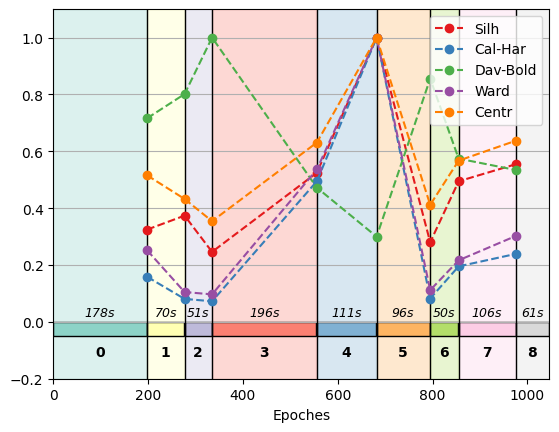

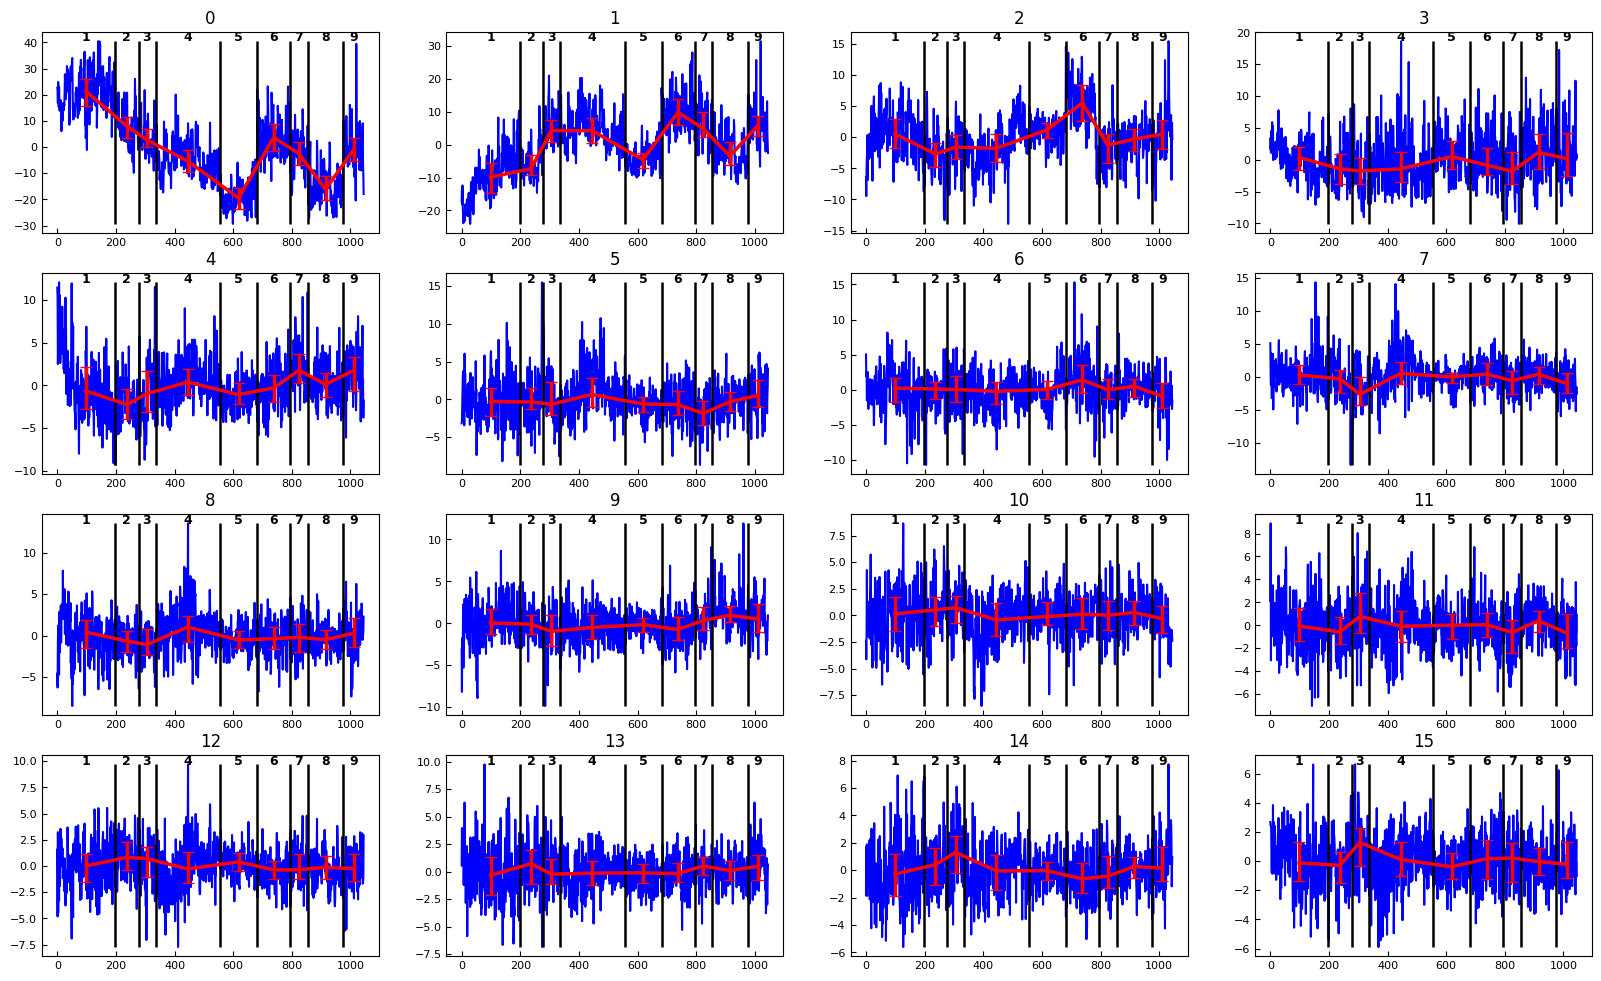

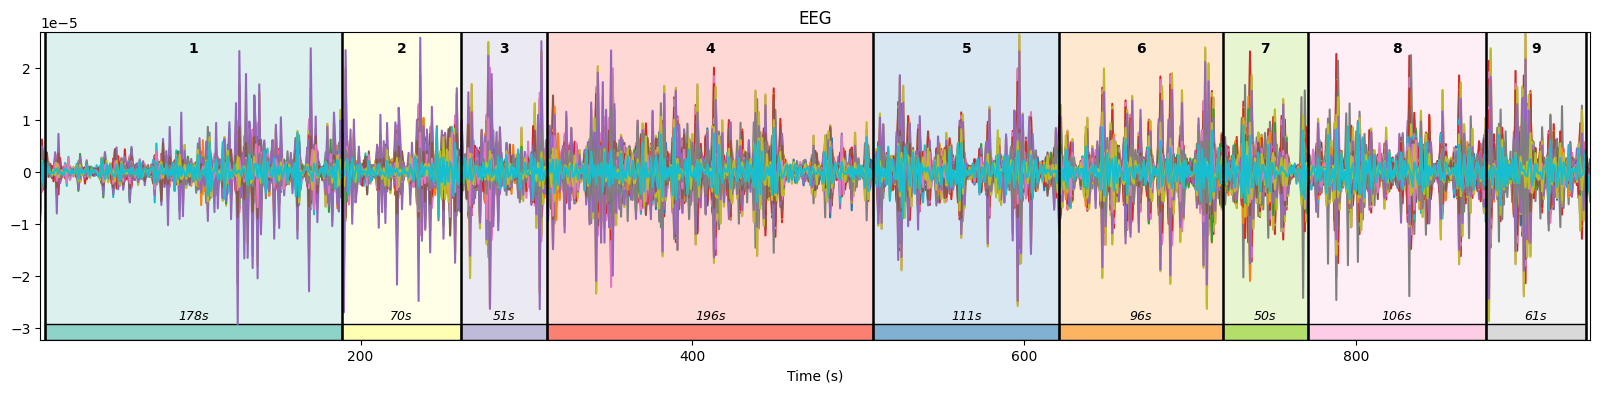

In [139]:
analyze(result, 'Avg-Silh', "internal")
# [   0   39  282  492  560  682  784  857  976 1046]
# array([   0,   46,  210,  340,  554,  682,  784,  846,  975, 1046])

![Alternative Text][1707850881559]

[1707850881559]: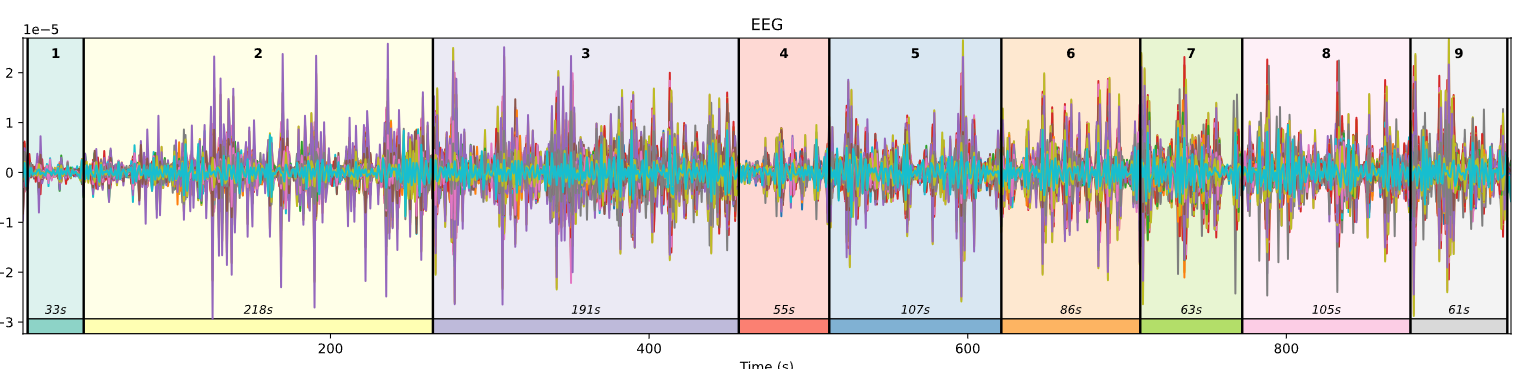

#### External

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,35,10,3,Mode,"[0, 277, 682, 1046]",65535.70,16.47,1.08e-01,300.25,4.10,0.20,276.69,3.30,0.68,0.48,0.64
1,60,45,15,4,Median,"[0, 265, 558, 855, 1046]",31251.78,12.12,6.88e-02,211.39,4.36,0.14,142.33,3.83,0.75,0.61,0.71
2,60,40,10,5,Median,"[0, 277, 554, 682, 846, 1046]",45083.21,20.87,7.74e-02,250.79,2.52,0.30,247.02,1.24,0.82,0.73,0.80
3,60,35,20,6,Mode,"[0, 277, 558, 682, 856, 976, 1046]",41145.74,21.45,6.56e-02,228.17,4.07,0.32,230.95,1.12,0.88,0.79,0.83
4,20,35,10,7,Median,"[0, 43, 277, 554, 682, 842, 976, 1046]",33194.44,19.88,1.66e-02,204.77,3.68,0.28,191.42,1.27,0.88,0.82,0.86
5,0,35,10,8,Median,"[0, 43, 239, 277, 554, 682, 842, 976, 1046]",20314.38,17.78,1.51e-02,188.03,3.44,0.24,126.20,1.42,0.86,0.76,0.80
6,0,40,10,9,Mode,"[0, 43, 239, 277, 486, 558, 682, 795, 976, 1046]",14148.46,15.63,-2.26e-03,164.70,3.51,0.21,94.57,1.64,0.90,0.84,0.86
7,20,40,10,10,Mode,"[0, 43, 239, 277, 486, 558, 682, 795, 855, 976...",11943.96,15.30,-1.08e-04,161.66,3.54,0.21,84.69,1.63,0.92,0.88,0.90
8,20,40,10,11,Mode,"[0, 43, 239, 277, 343, 486, 558, 682, 795, 855...",10637.01,14.28,3.19e-03,150.27,3.40,0.20,76.07,1.81,0.90,0.81,0.84
9,0,50,20,12,Median,"[0, 44, 198, 263, 277, 335, 486, 556, 682, 795...",9822.72,13.76,6.97e-03,143.36,3.37,0.20,70.54,1.90,0.88,0.76,0.80


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,40,10,9,Mode,"[0, 43, 239, 277, 486, 558, 682, 795, 976, 1046]",14148.46,15.63,-2.26e-03,164.7,3.51,0.21,94.57,1.64,0.9,0.84,0.86


array([   0,   43,  239,  277,  486,  558,  682,  795,  976, 1046])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.12,32.23,1.84,6364.06,13.43
1,0.15,34.27,1.73,7065.44,14.90
2,0.19,32.34,1.82,6104.67,13.78
3,0.06,33.01,2.21,5512.29,10.15
4,0.24,79.97,1.43,7030.25,12.42
5,0.50,362.66,0.75,46244.36,27.97
6,0.27,141.09,1.30,26592.90,19.55
7,0.14,40.96,2.05,8273.70,12.80


,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 47.5)","(48.3, 222.7)","(225.1, 259.5)","(260.3, 449.9)","(450.7, 509.9)","(510.7, 620.3)","(621.1, 717.1)","(719.5, 877.1)","(877.9, 938.7)"
"Time length, sec",37.6,174.4,34.4,189.6,59.2,109.6,96.0,157.6,60.8
Number of epochs,43,196,38,209,72,124,113,181,70


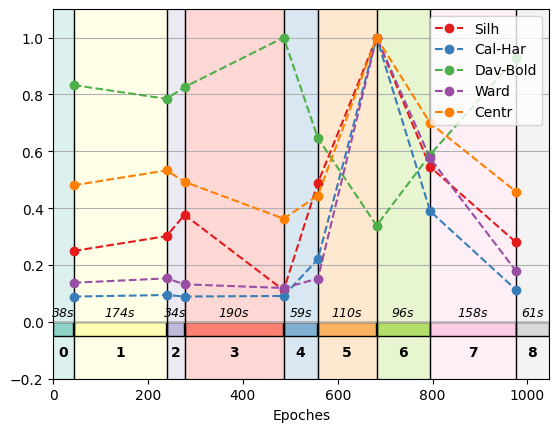

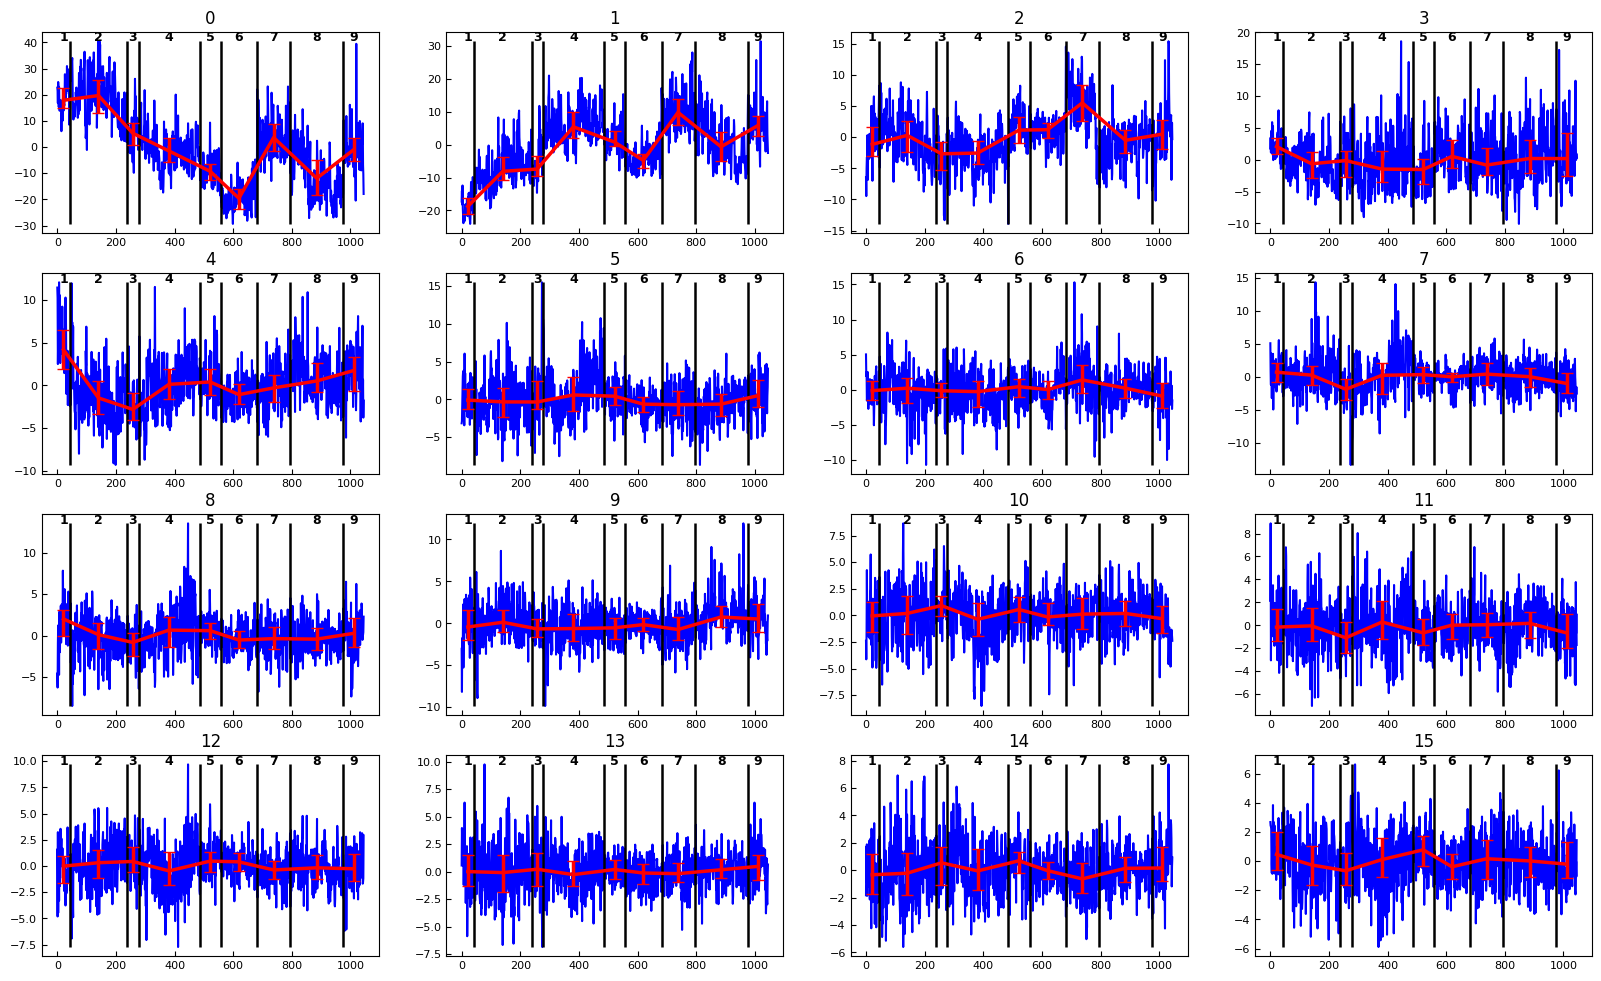

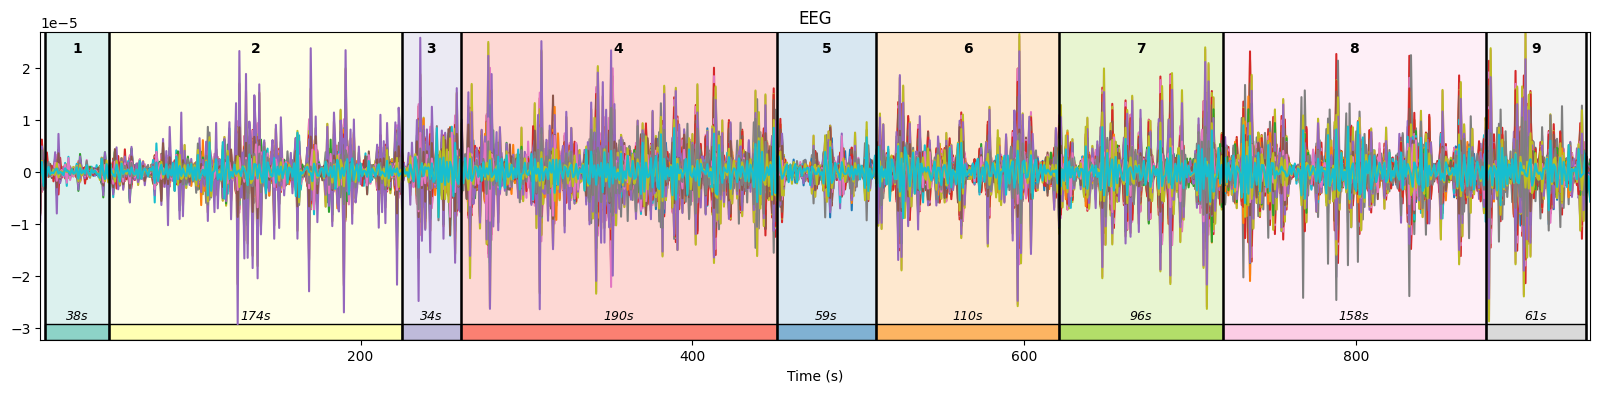

In [140]:
if exp != "reproduction":
    analyze(result, 'FMI', "external")
# [   0   39  282  492  560  682  784  857  976 1046]

![Alternative Text][1707850881559]

[1707850881559]: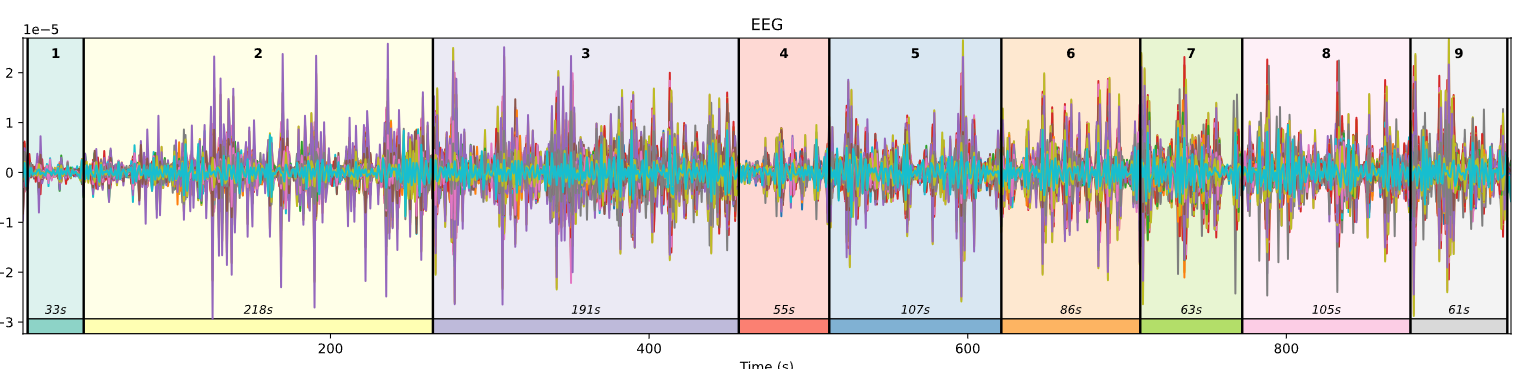